In [1]:
import sys
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Determine the directory where the notebook is being executed
notebook_dir = Path().resolve()

# Construct file paths relative to the notebook directory
project_path = notebook_dir.parent
reconstruction_path = project_path / 'recon'
data_path = project_path / 'data'

# Add the project and reconstruction directories to the Python path
if str(project_path) not in sys.path:
    sys.path.append(str(project_path))
if str(reconstruction_path) not in sys.path:
    sys.path.append(str(reconstruction_path))
if str(data_path) not in sys.path:
    sys.path.append(str(data_path))
    
from parser.parse_mf4 import read_MF4
from parser.utils import save_parsed_data, load_parsed_data
import sigma

data_path = project_path / 'data'
file_path = data_path / '8-O-16g.jeff33' #'n-074_W_181.endf'
parsed_data_path = data_path / 'parsed_data_O16.pkl'

print("Data file found:", os.path.exists(file_path))

Data file found: True


In [2]:
# Parse the file and save the data if not already done
try:
    legendre_data, tabulated_data, ltt = load_parsed_data(parsed_data_path)
    print("Loaded parsed data from file.")
except FileNotFoundError:
    ltt, legendre_data, tabulated_data = read_MF4(file_path, targetMT=2)
    save_parsed_data(parsed_data_path, legendre_data, tabulated_data, ltt)
    print("Parsed data from source file and saved.")

Parsed data from source file and saved.


In [3]:
ltt, legendre_data, tabulated_data = read_MF4(file_path, targetMT=2)
ltt = int(ltt)

In [4]:
print("Available energies in legendre_data:", list(legendre_data.keys()))
print("Available energies in tabulated_data:", list(tabulated_data.keys()))

Available energies in legendre_data: [1e-05, 31.855000000000004, 39.663, 47.47, 63.08500000000001, 78.701, 94.316, 109.92999999999999, 125.55000000000001, 156.78, 188.01000000000002, 219.24, 250.47000000000003, 312.93, 375.39, 500.31, 625.23, 750.16, 875.08, 1000.0, 1250.0, 1500.0, 2000.0, 2500.0, 3000.0, 4000.0, 5000.0, 6250.0, 7500.0, 8750.0, 10000.0, 12500.0, 15000.0, 20000.0, 25000.0, 30000.0, 40000.0, 50000.0, 62500.0, 75000.0, 87500.0, 100000.0, 125000.0, 150000.0, 175000.0, 200000.0, 220000.00000000003, 240000.0, 260000.0, 280000.0, 300000.0, 310000.0, 320000.0, 330000.0, 340000.0, 350000.0, 360000.0, 370000.0, 380000.0, 390000.0, 400000.0, 405000.0, 409999.99999999994, 415000.00000000006, 420000.0, 425000.0, 430000.0, 434999.99999999994, 440000.00000000006, 445000.0, 450000.0, 455000.0, 459999.99999999994, 465000.00000000006, 470000.0, 475000.0, 480000.0, 484999.99999999994, 490000.00000000006, 495000.0, 500000.0, 509999.99999999994, 520000.0, 530000.0, 540000.0, 550000.0, 5600

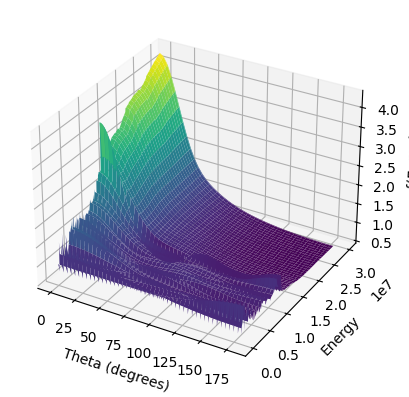

In [5]:
# Define the energy and mu ranges for the 3D plot
min_energy = 1e-5
max_energy = 3e7
num_points = 500
energy_values = np.linspace(min_energy, max_energy, num_points)
mu_values = np.linspace(-1, 1, num_points)
theta_values = np.linspace(0, 180, 180)

# Compute f(E, mu) for the 3D plot
f_values = np.zeros((num_points, len(theta_values)))
for i, energy in enumerate(energy_values):
    for j, theta in enumerate(theta_values):
    #for j, mu in enumerate(mu_values):
        mu = np.cos(np.radians(theta))
        try:
            f_values[i, j] = sigma.sigma(mu, energy, legendre_data, tabulated_data, 1)  # Change LTT as needed
        except ValueError as e:
            print(f"Error for mu={mu}, energy={energy}: {e}")

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(theta_values, energy_values)
ax.plot_surface(X, Y, f_values, cmap='viridis')

# ax.set_xlabel('mu')

# # Plot the results
# plt.figure(figsize=(10, 6))
# for i, energy in enumerate(energy_values[::20]):  # Plot every 20th energy value for clarity
#     plt.plot(theta_values, f_values[20 * i, :], label=f'Energy = {energy:.2e} eV')

plt.xlabel('Theta (degrees)')
ax.set_ylabel('Energy')
ax.set_zlabel('f(E, mu)')
plt.show()


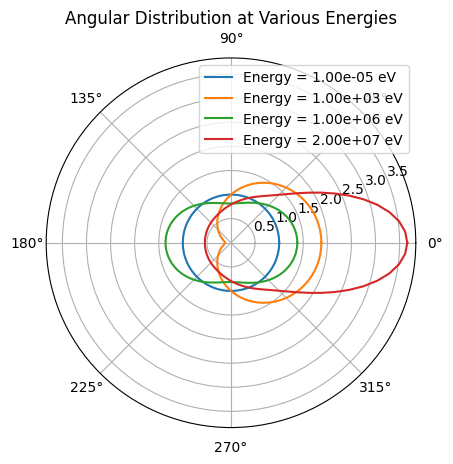

In [6]:
def plot_polar_distribution(energies, legendre_data, tabulated_data, num_samples=100):
    theta_values = np.linspace(0, 360, num_samples)
    results = {}

    plt.figure()
    for energy in energies:
        f_values = np.zeros(num_samples)
        for i, theta in enumerate(theta_values):
            mu = np.cos(np.radians(theta))
            try:
                f_values[i] = sigma.sigma(mu, energy, legendre_data, tabulated_data, 1)
            except RuntimeError as e:
                print(f"Error for mu={mu}, energy={energy}: {e}")
                f_values[i] = 0

        results[energy] = f_values
        plt.polar(np.radians(theta_values), f_values, label=f"Energy = {energy:.2e} eV")

    plt.title("Angular Distribution at Various Energies")
    plt.legend()
    plt.show()

# Define energies and angles
energies = [1e-05, 1e3, 1e6, 2e7]  # Low, medium, and high energies

# Call the function to plot
plot_polar_distribution(energies, legendre_data, tabulated_data)

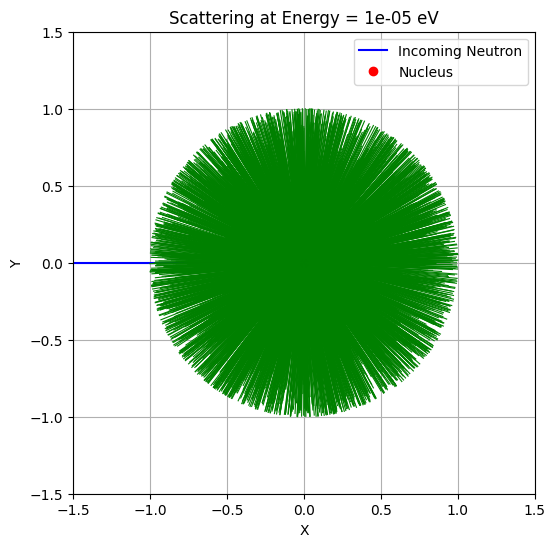

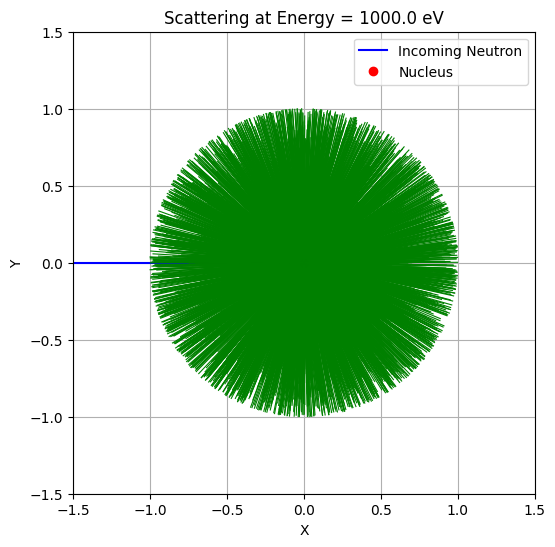

In [8]:
# Function to sample scattering angles
def sample_scattering_angles(energy, num_samples=25):
    theta_values = np.linspace(0, 360, num_samples)
    sigma_values = np.zeros(len(theta_values))
    
    for j, theta in enumerate(theta_values):
        mu = np.cos(np.radians(theta))  # Convert theta to mu
        try:
            sigma_values[j] = sigma.sigma(mu, energy, legendre_data, tabulated_data, 1)
        except ValueError as e:
            print(f"Error for mu={mu}, energy={energy}: {e}")

    sigma_values /= np.sum(sigma_values)  # Normalize the distribution
    sampled_thetas = np.random.choice(theta_values, num_samples, p=sigma_values)
    return sampled_thetas

# Plotting function
def plot_scattering(energy, sampled_thetas):
    plt.figure(figsize=(6, 6))
    nucleus = [0, 0]
    
    # Plot incoming neutron
    plt.plot([0, -2], [0, 0], label='Incoming Neutron', color='blue')
    
    # Plot nucleus
    plt.plot(nucleus[0], nucleus[1], 'ro', label='Nucleus')
    
    # Plot scattered neutrons
    for theta in sampled_thetas:
        phi = np.random.uniform(0, 2 * np.pi)  # Random azimuthal angle
        x = np.cos(np.radians(theta)) * np.cos(phi)
        y = np.cos(np.radians(theta)) * np.sin(phi)
        plt.plot([0, x], [0, y], color='green', linewidth=0.8)
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Scattering at Energy = {energy} eV')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# Generate and plot the scattering for each energy
for energy in [1e-5, 1e3]:
    sampled_thetas = sample_scattering_angles(energy, 5000)
    plot_scattering(energy, sampled_thetas)